## Simulations
We simulate an FeGe disk of diameter 160 nm and thickness 10 nm in a varying external field ($\mu_{0}$**H**) from 0 T to 1.2 T. The simulations start from multiple initial configurations.
### Initial configurations

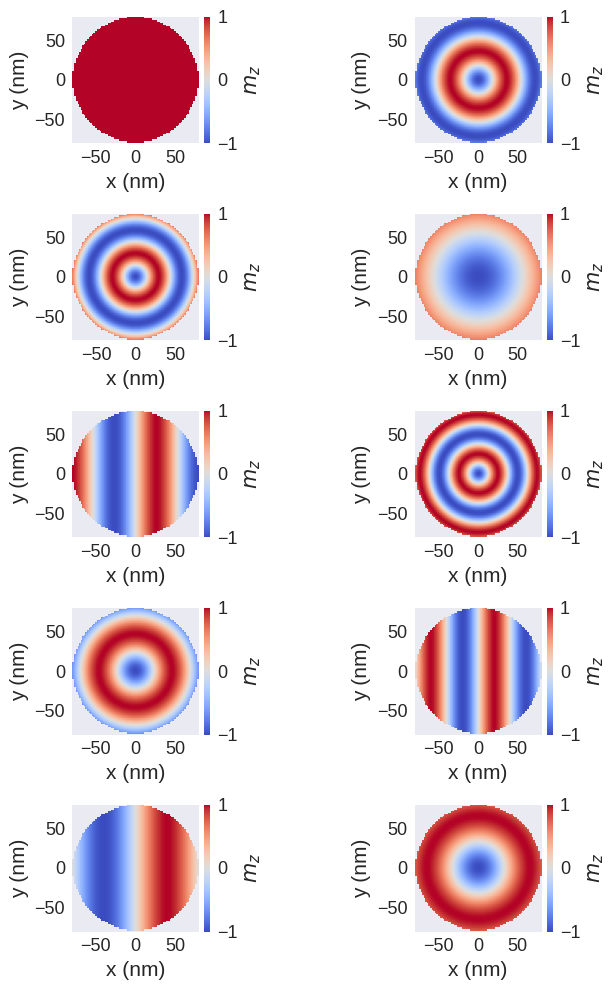

In [1]:
%matplotlib inline
import pathlib as pl

import discretisedfield as df
import matplotlib.pyplot as plt

paths = pl.Path("sims/Configs_0/").glob("drive-[0-9]/m0.omf")
fig, ax = plt.subplots(nrows=5, ncols=2)
for i, path in enumerate(paths):
    row, column = divmod(i, 2)
    field = df.Field.from_file(path).orientation
    field.valid = "norm"
    field.z.sel("z").mpl.scalar(
        ax=ax[row, column], clim=(-1, 1), cmap="coolwarm", colorbar_label="$m_z$",
    )
fig.set_size_inches(7, 10)
plt.tight_layout()
plt.show()

### Energy contributions
$E = \int_V \biggl[ - A \mathbf{m} \cdot \nabla^{2} \mathbf{m} + D \mathbf{m} \cdot (\nabla \times \mathbf{m}) -\mu_{0}M_\text{s} \mathbf{m} \cdot \mathbf{H}-\frac{1}{2}\mu_{0}M_\text{s} \mathbf{m} \cdot \mathbf{H}_\text{d} \biggr] \textrm{d}V$

The equilibrium configurations are obtained by minimizing the energy.

## Training the CNN auto-encoder
The network topology:
<div>
<img src="images/autoencoder.png" width="700"/>
</div>

In [2]:
import numpy as np
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split

2023-09-28 16:19:42.900668: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 16:19:42.923088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 16:19:43.116629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 16:19:43.118217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 16:19:43.908479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
simulation_file_paths = list(
    pl.Path("sims").glob("Configs_*/drive-[0-9]/Configs_*.omf")
)

In [4]:
sim_arr = np.array([df.Field.from_file(file).orientation.sel("z").array for file in simulation_file_paths])

In [5]:
import json


parameters_dict = {}
for path in simulation_file_paths:
    json_file_path = path.parent / "parameters_DE.json"
    with open(json_file_path, "r", encoding="utf-8") as f_handle:
        parameters_dict[str(path)] = json.load(f_handle)

In [6]:
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [7]:
print(train_set.shape[0], valid_set.shape[0], test_set.shape[0])

1926 482 602


In [8]:
encoder = ks.models.Sequential(
    [
        ks.layers.InputLayer(input_shape=(80, 80, 3)),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            3,
            kernel_size=8,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(40, 40, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            3,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(20, 20, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            6,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(10, 10, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            12,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(5, 5, 6),
        ),
        ks.layers.MaxPool2D(pool_size=5),  # image size 1 X 1 x 12
    ],
    name="encoder",
)

In [9]:
decoder = ks.models.Sequential(
    [
        ks.layers.Conv2DTranspose(
            6,
            kernel_size=4,
            strides=5,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(1, 1, 12),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(5, 5, 6),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(10, 10, 3),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(20, 20, 3),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=8,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(80, 80, 3),
        ),
    ],
    name="decoder",
)

In [10]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2  (None, 40, 40, 3)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 3)         579       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 3)         147       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 3)         0         
 g2D)                                                            
                                                           

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 5, 5, 6)           1158      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 10, 10, 3)         291       
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 20, 20, 3)         147       
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 40, 40, 3)         147       
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 80, 80, 3)         579 

In [12]:
auto_encoder = ks.models.Sequential([encoder, decoder], name="autoencoder")

In [13]:
auto_encoder.compile(
    loss="MSE",
    optimizer=ks.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
)

In [14]:
history = auto_encoder.fit(
    train_set, train_set, epochs=15, validation_data=(valid_set, valid_set)
)

Epoch 1/15
61/61 [==============================] - 2s 20ms/step - loss: 0.2095 - val_loss: 0.1212
Epoch 2/15
61/61 [==============================] - 1s 17ms/step - loss: 0.0818 - val_loss: 0.0540
Epoch 3/15
61/61 [==============================] - 1s 17ms/step - loss: 0.0470 - val_loss: 0.0402
Epoch 4/15
61/61 [==============================] - 1s 17ms/step - loss: 0.0366 - val_loss: 0.0328
Epoch 5/15
61/61 [==============================] - 1s 16ms/step - loss: 0.0307 - val_loss: 0.0289
Epoch 6/15
61/61 [==============================] - 1s 16ms/step - loss: 0.0272 - val_loss: 0.0260
Epoch 7/15
61/61 [==============================] - 1s 16ms/step - loss: 0.0247 - val_loss: 0.0238
Epoch 8/15
61/61 [==============================] - 1s 16ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 9/15
61/61 [==============================] - 1s 16ms/step - loss: 0.0213 - val_loss: 0.0209
Epoch 10/15
61/61 [==============================] - 1s 17ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 11/

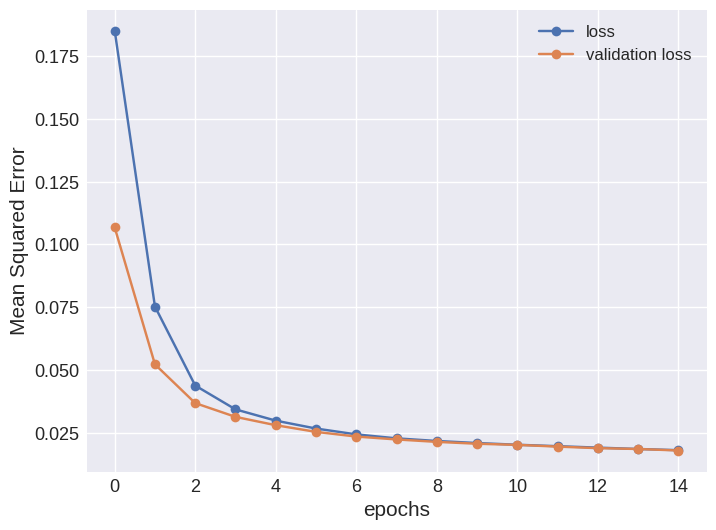

In [15]:
plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

In [15]:
auto_encoder.evaluate(test_set, test_set)

19/19 [==============================] - 0s 10ms/step - loss: 0.0161


0.016067076474428177

### Autoencoder visualisation

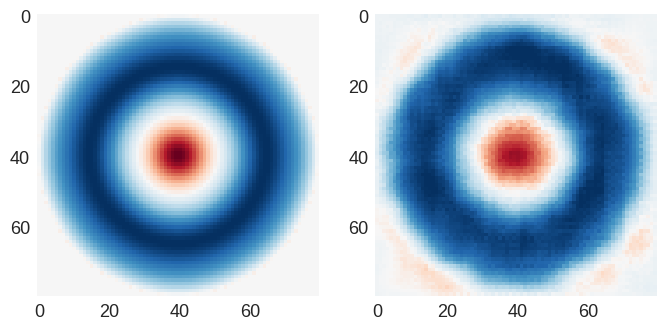

In [16]:
i = 25
in_sim = test_set[i : i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

## Feature extractor

In [17]:
feature_extractor = ks.models.Sequential(
    [
        auto_encoder.get_layer("encoder"),
        ks.layers.Flatten(),
    ]
)

In [18]:
feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

In [19]:
feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 0s - 245ms/epoch - 3ms/step


## Clustering

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [21]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(feature_arr)
distances, indices = neighbors_fit.kneighbors(feature_arr)

In [22]:
distances_sorted = np.sort(distances, axis=0)

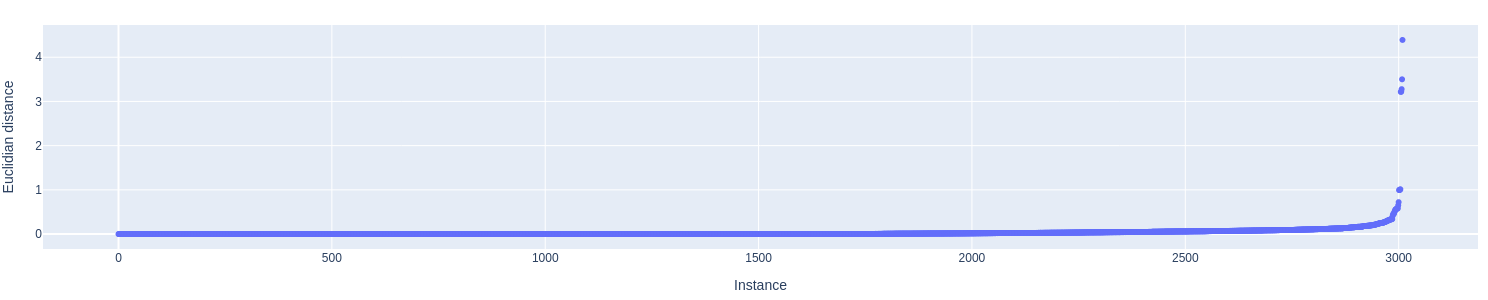

In [86]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = list(range(distances_sorted.shape[0])),
        y = distances_sorted[:, -1],
        mode="markers",
    )
)
fig.update_layout(
    autosize=False,
    width=990,
    height=300,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title="Instance",
    yaxis_title="Euclidian distance",
)

In [24]:
dbscan = DBSCAN(eps=0.64, min_samples=5)

In [25]:
dbscan.fit(feature_arr)
dbscan.labels_.max()

12

## Comparing results

In [26]:
class_dict = {f"Class {i}": list() for i in range(dbscan.labels_.max() + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

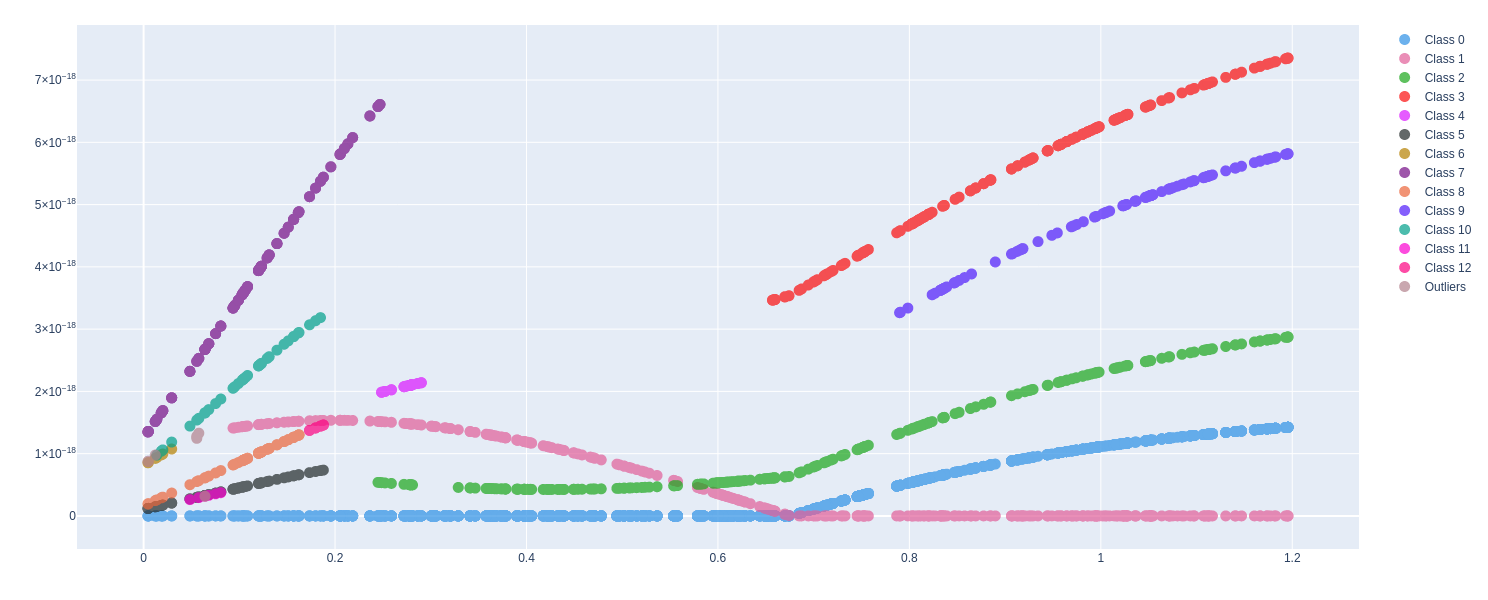

In [84]:
import plotly.graph_objs as go
import plotly.express as ptx


traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

![Published results](images/phase-paper.jpg)

In [62]:
from plotting import plot_all_examples

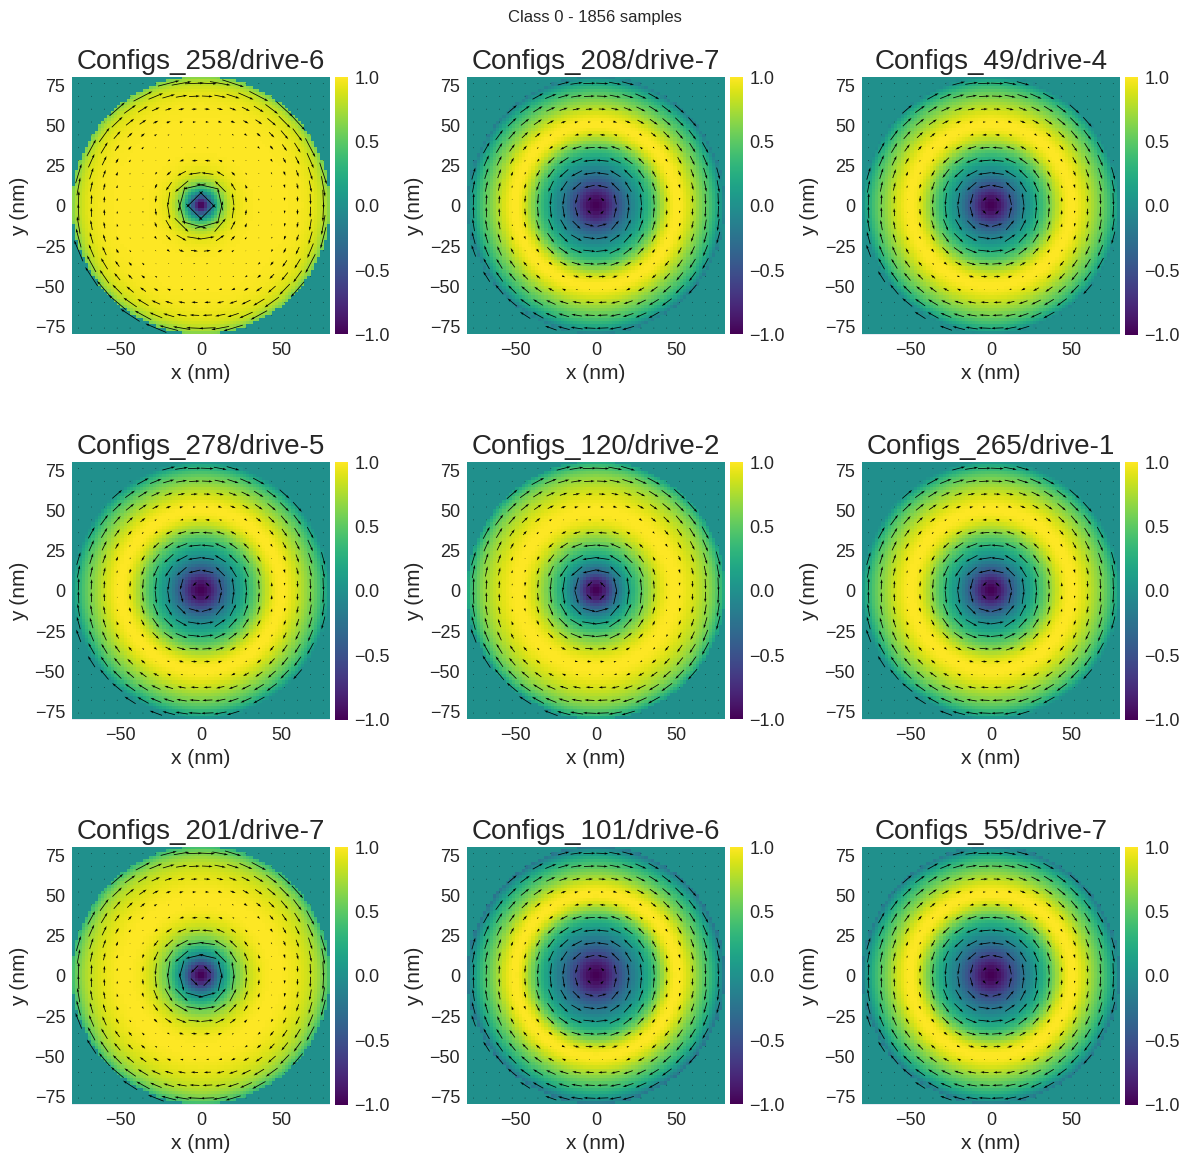

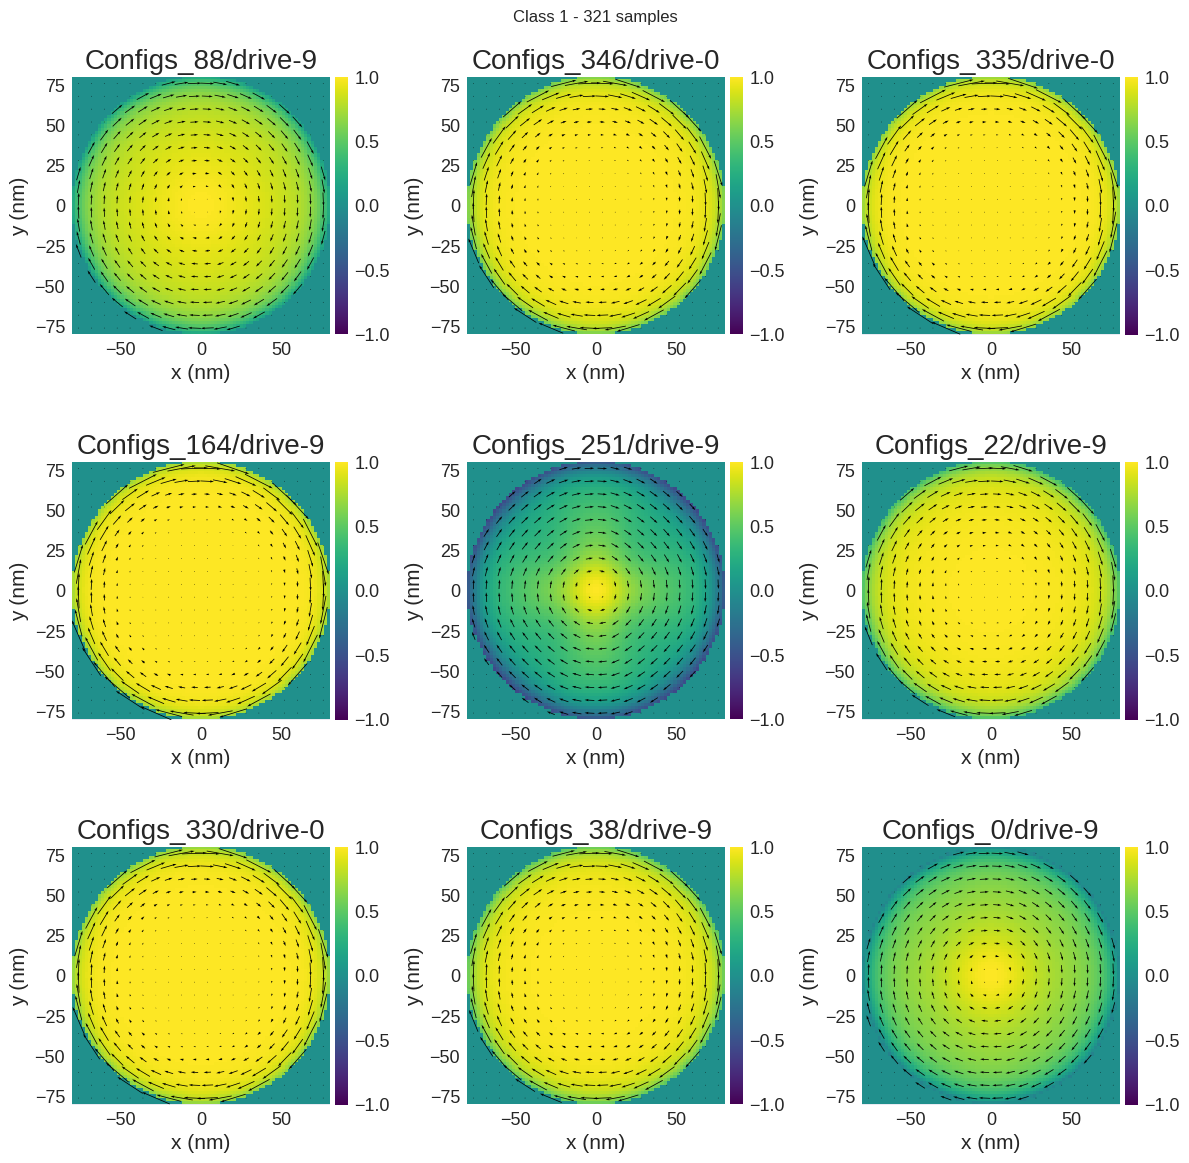

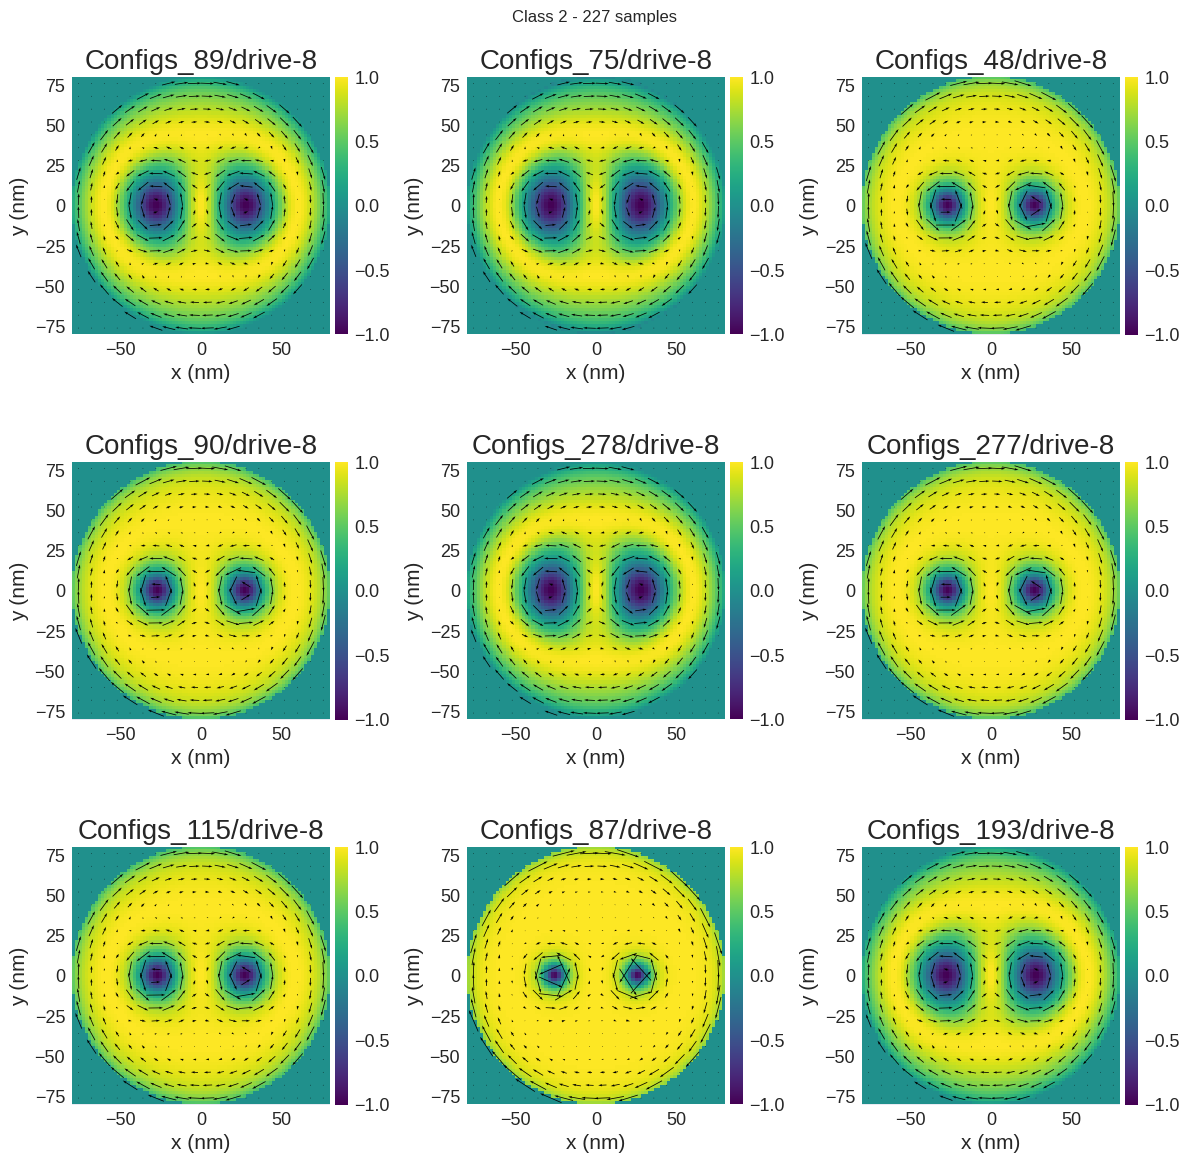

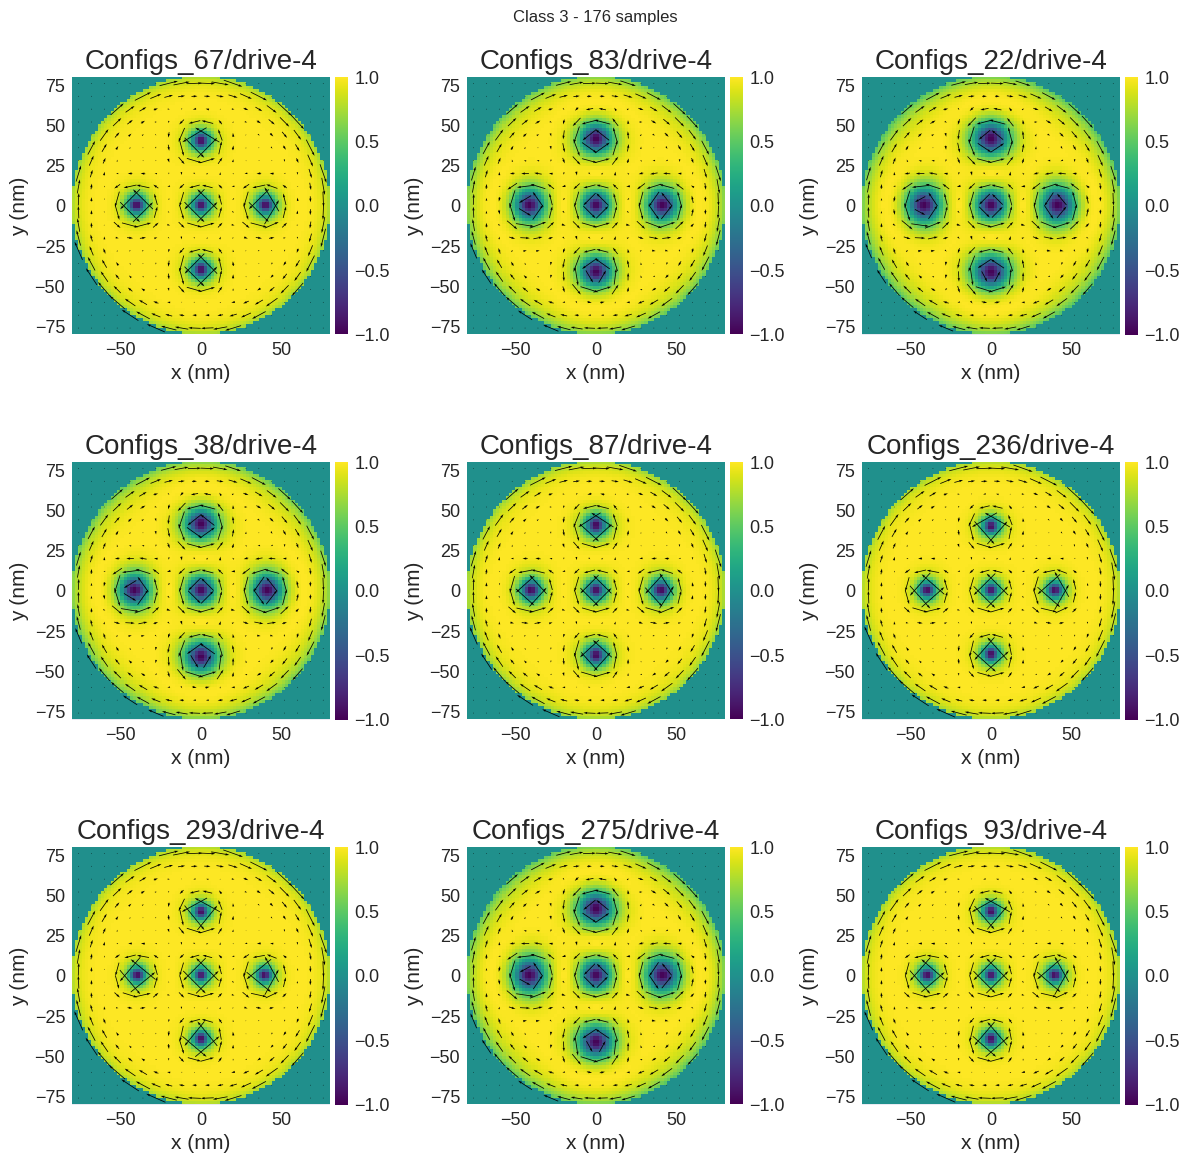

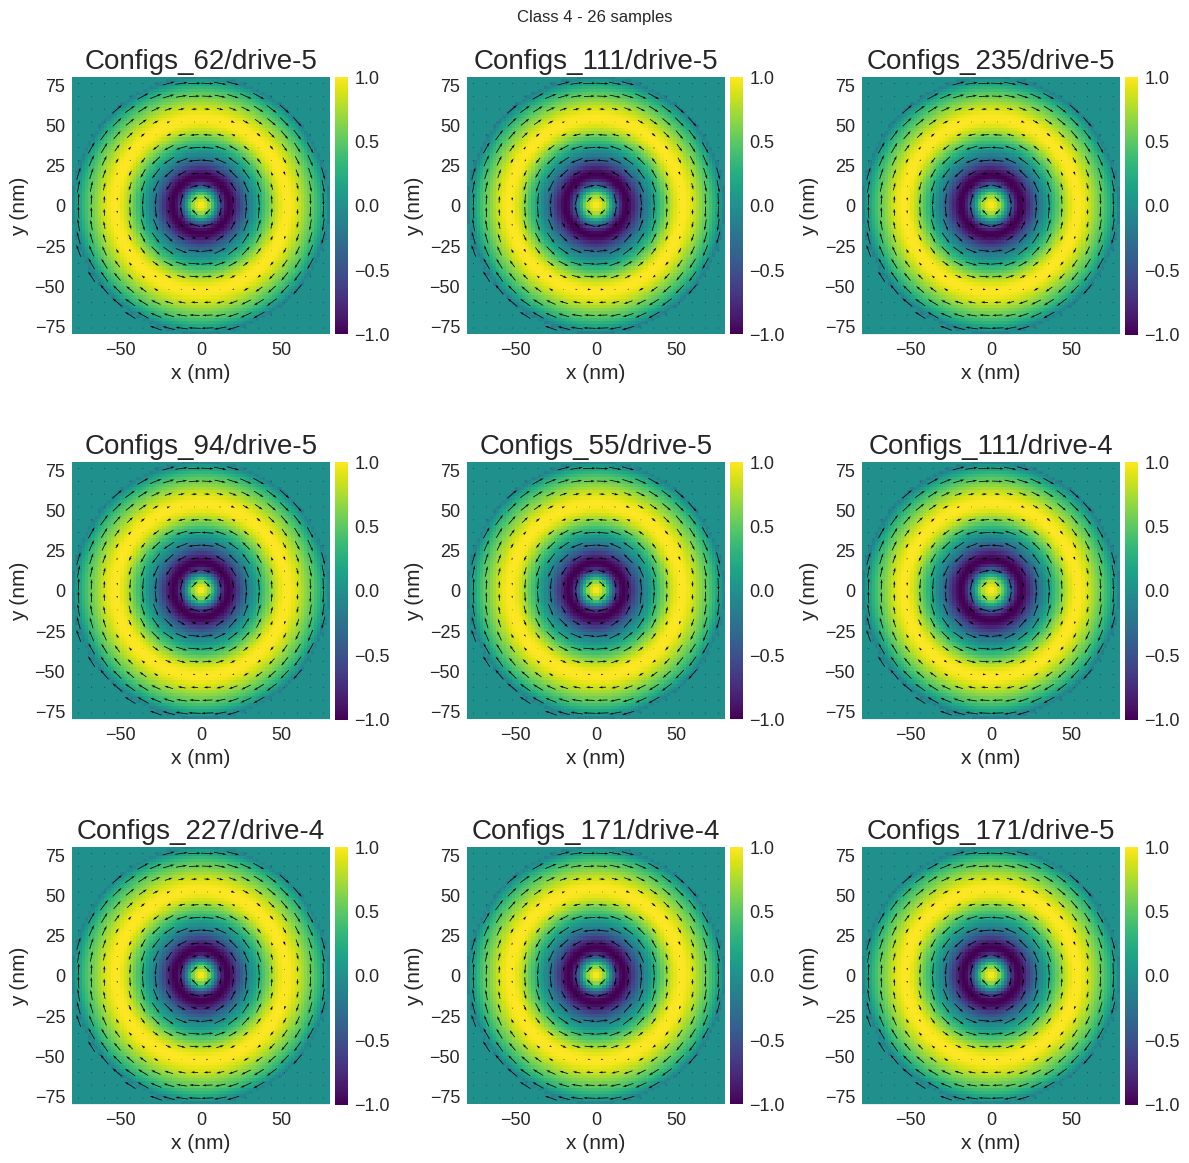

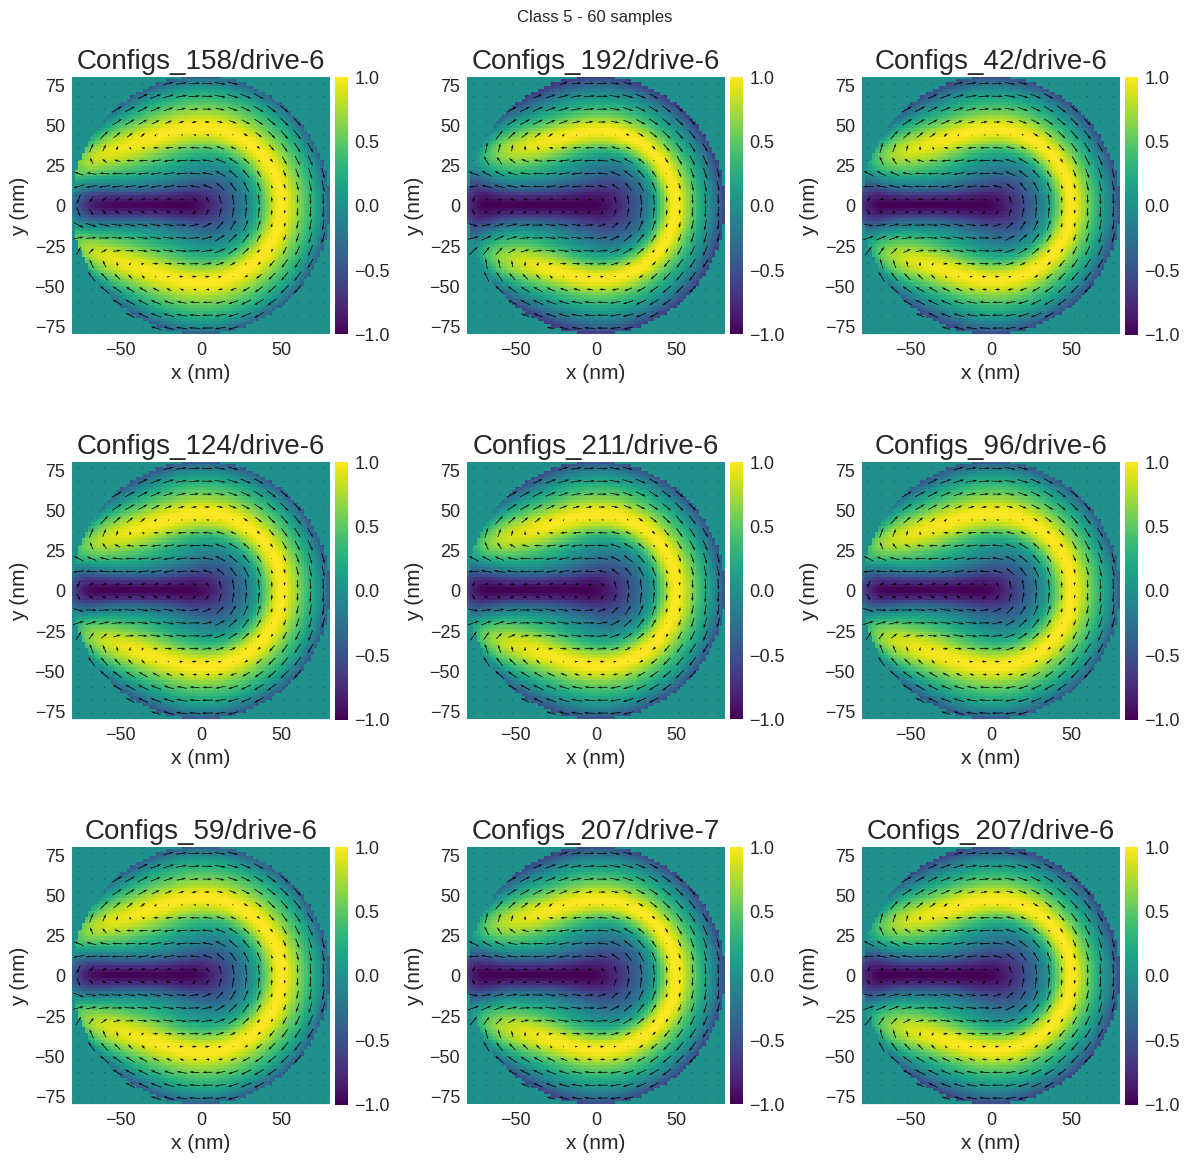

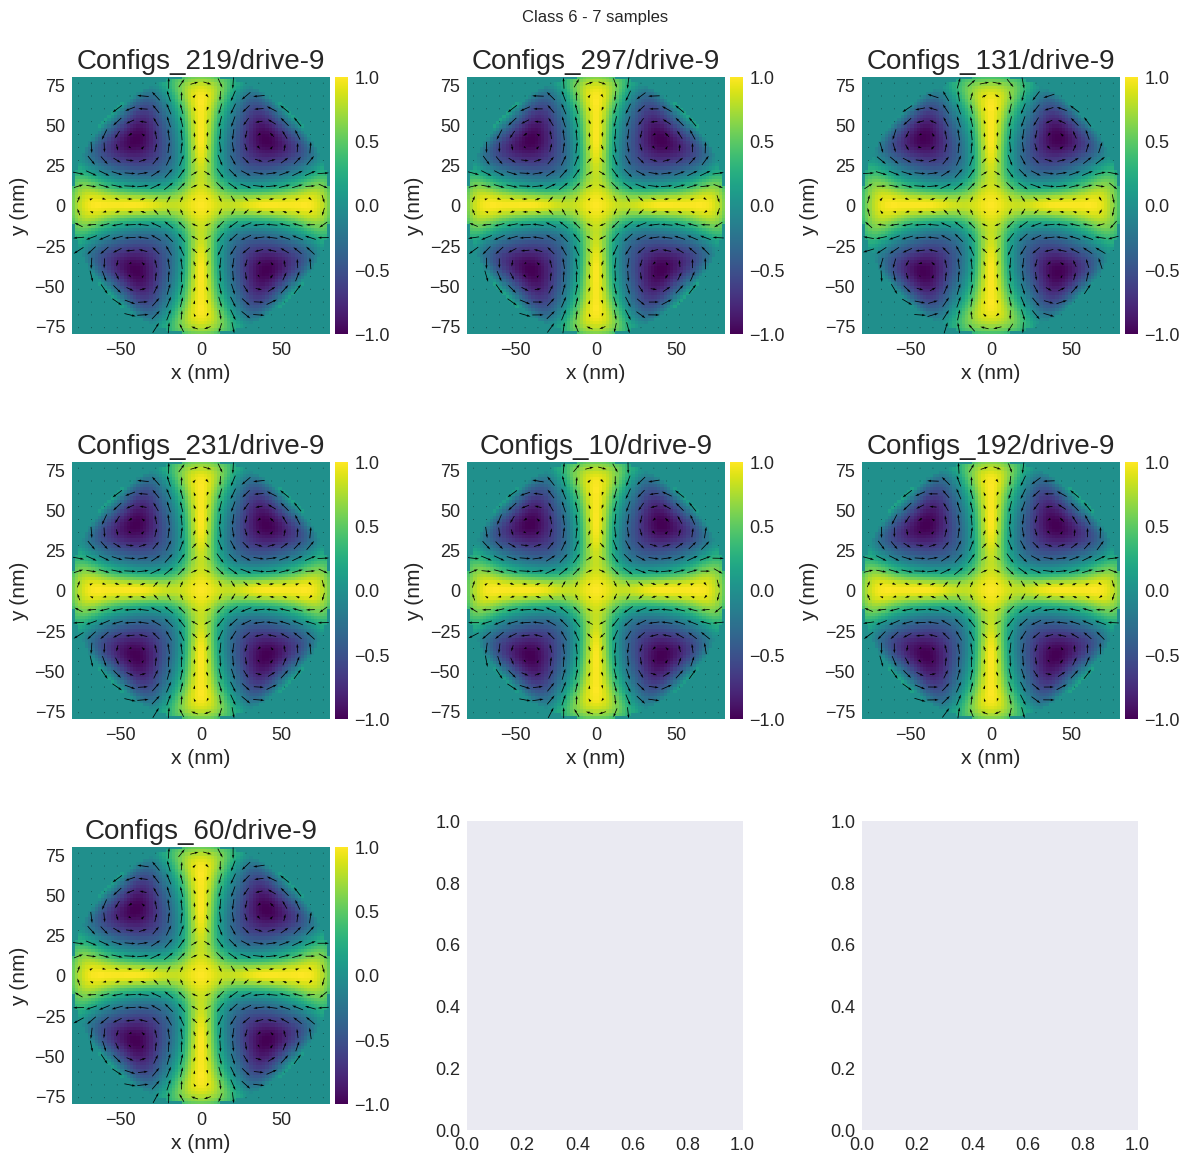

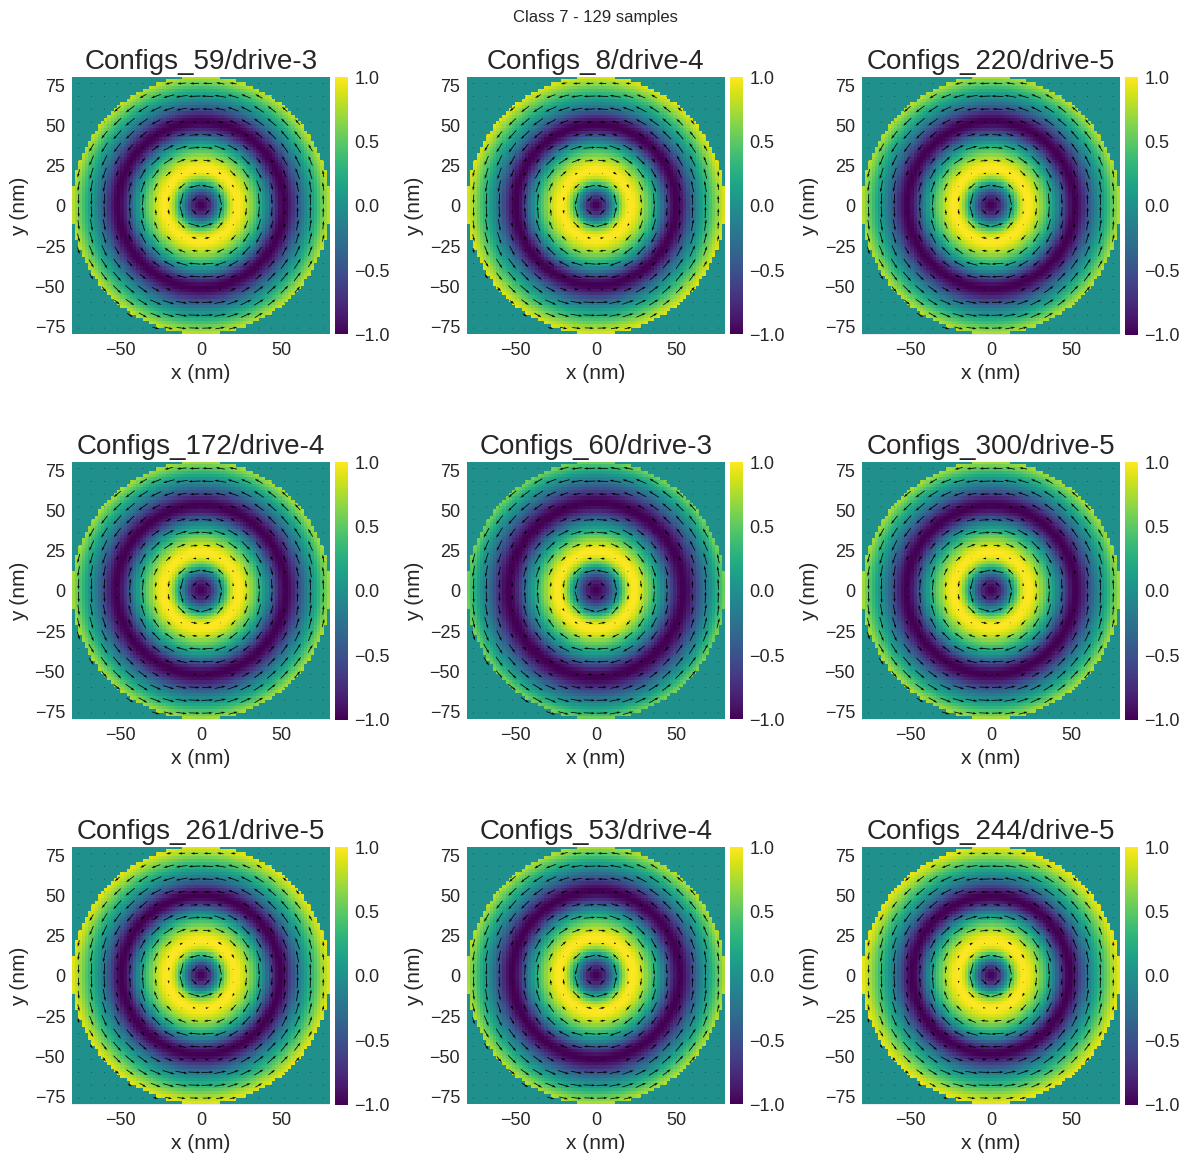

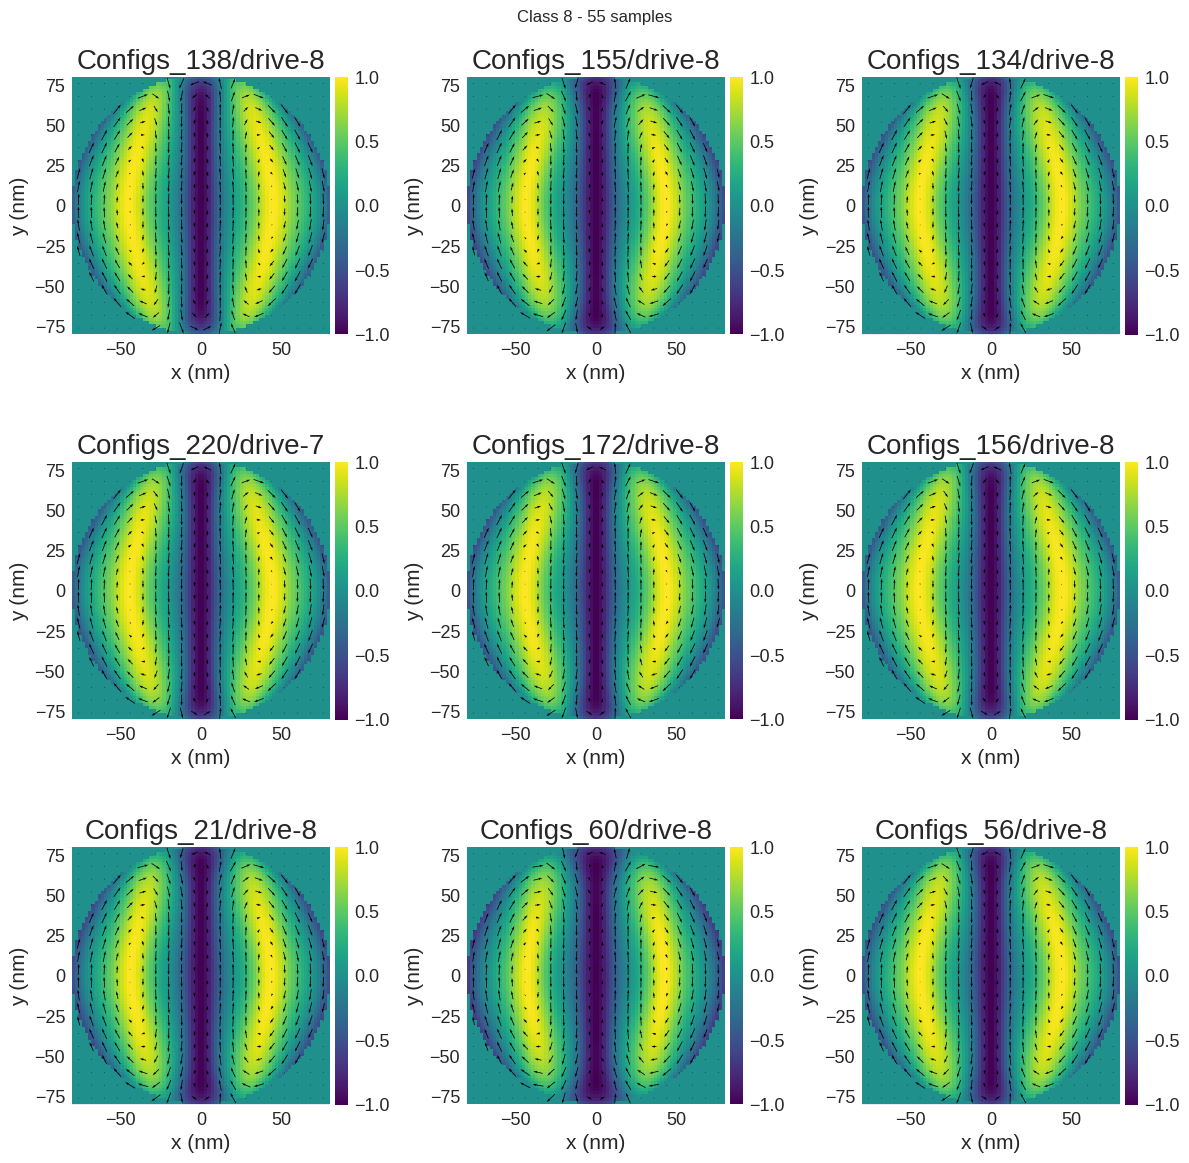

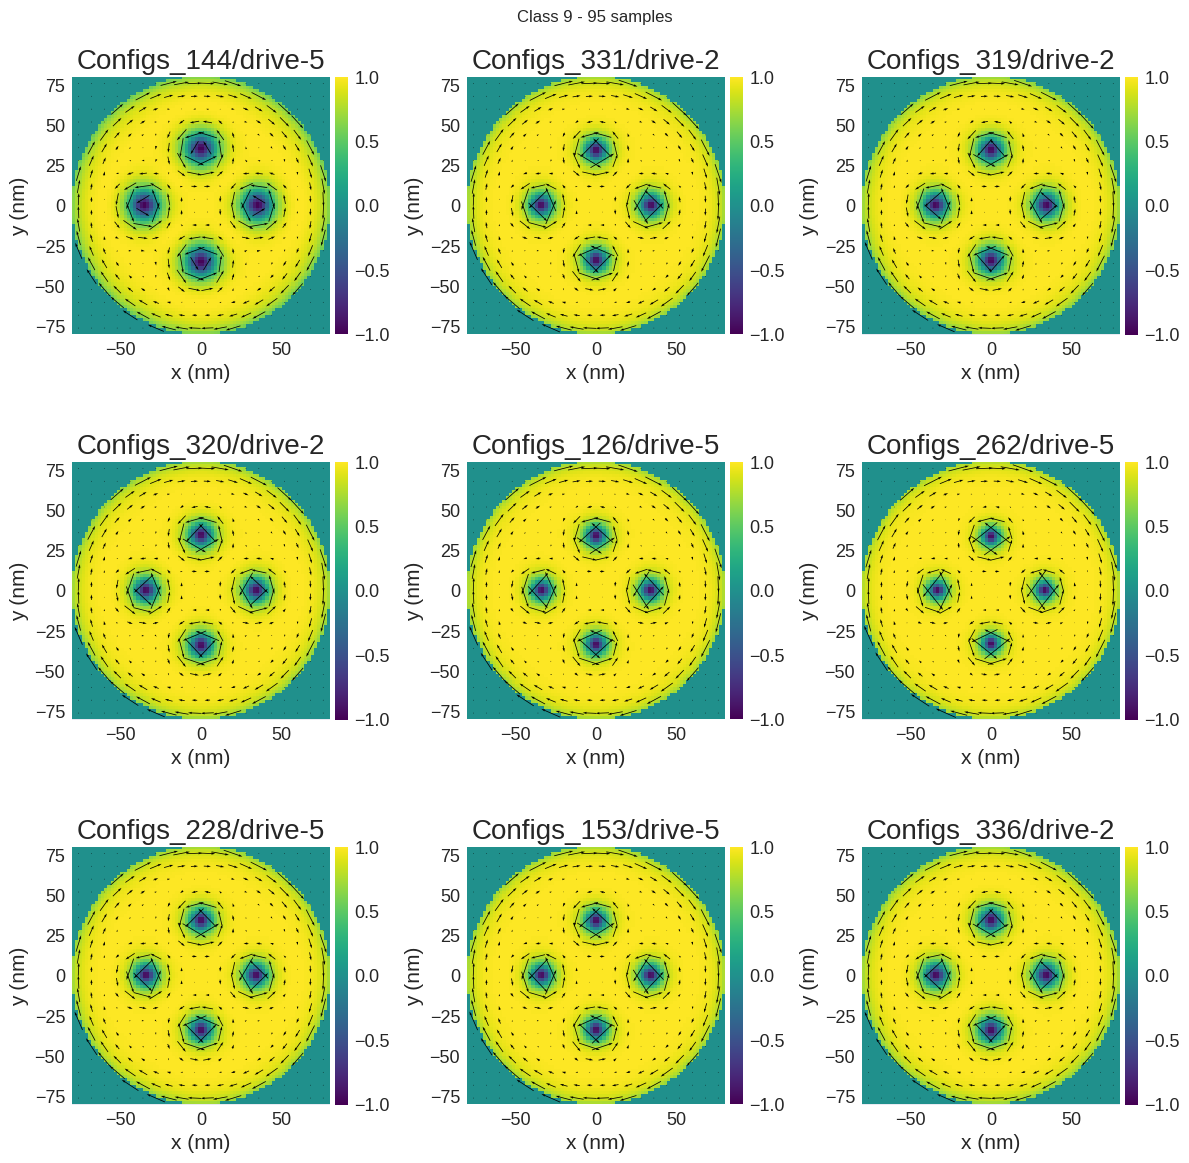

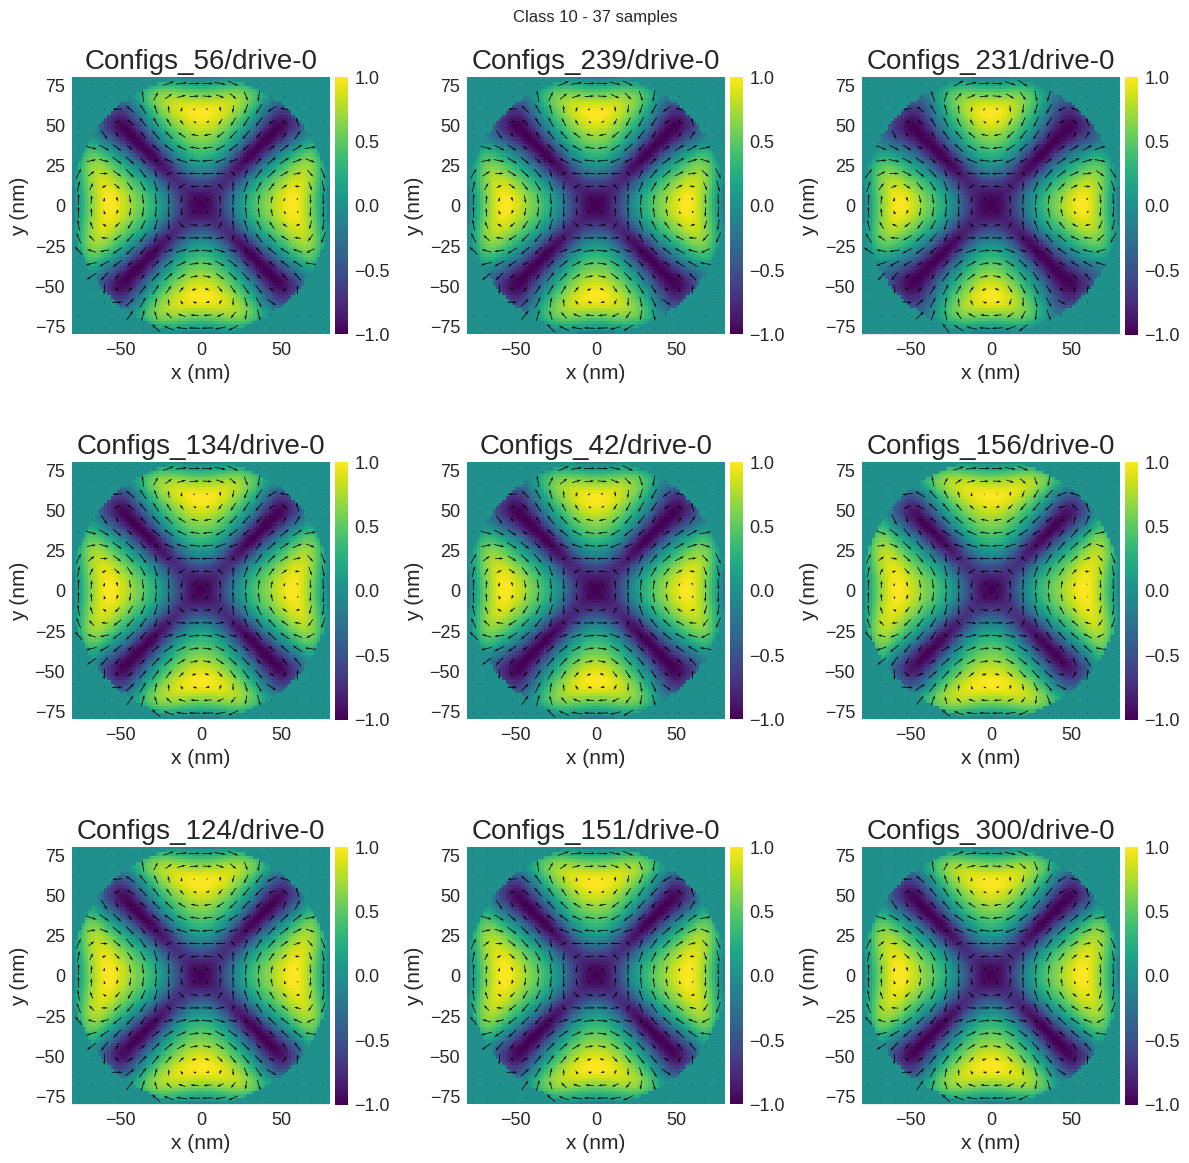

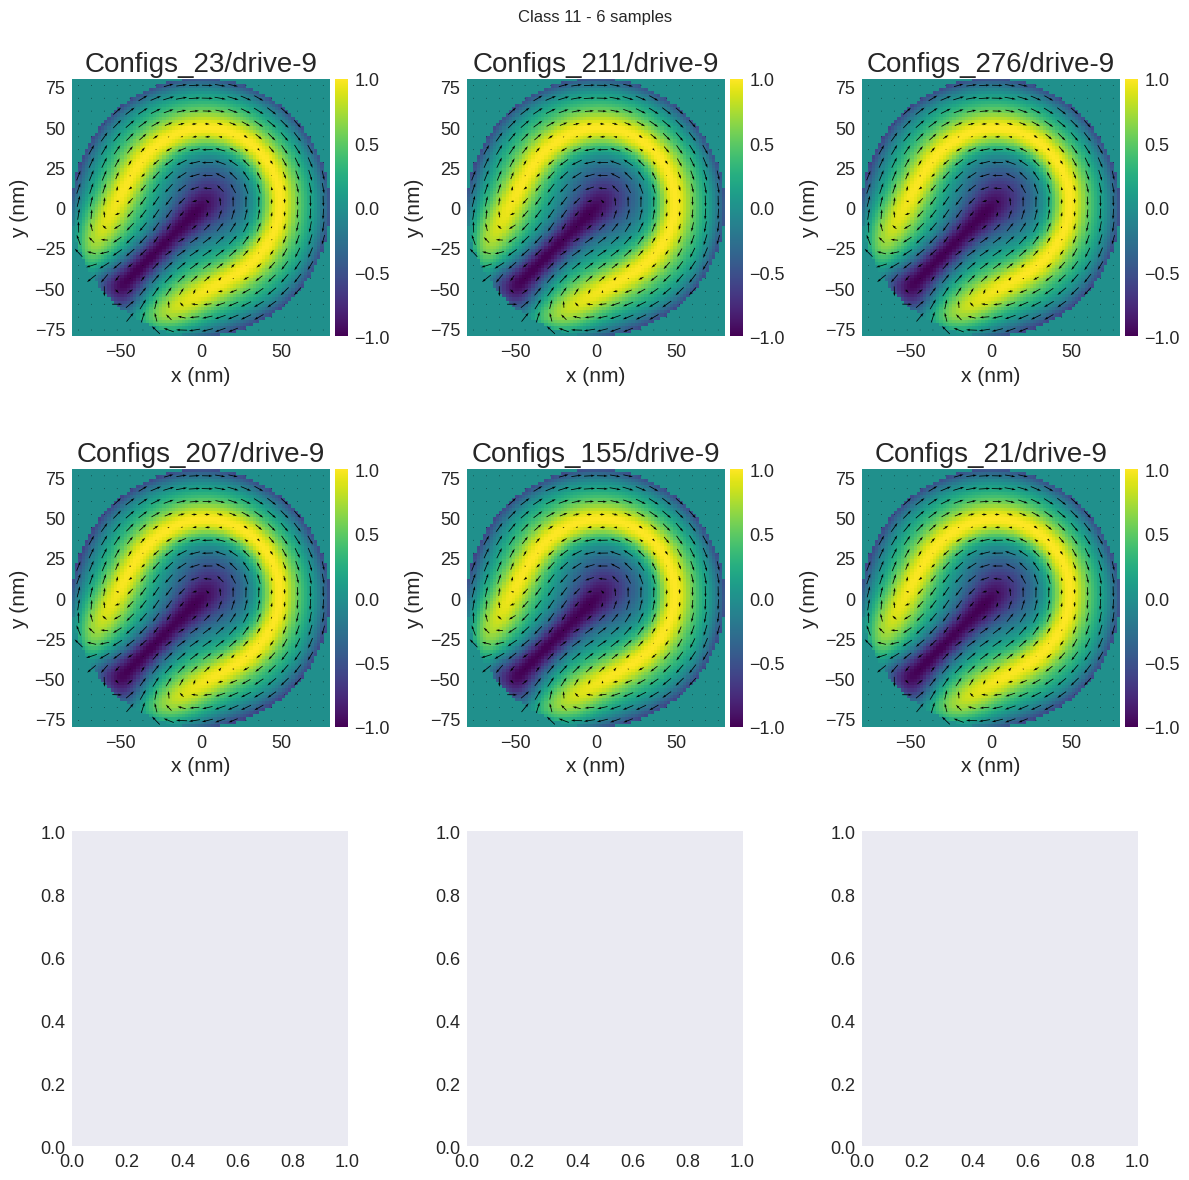

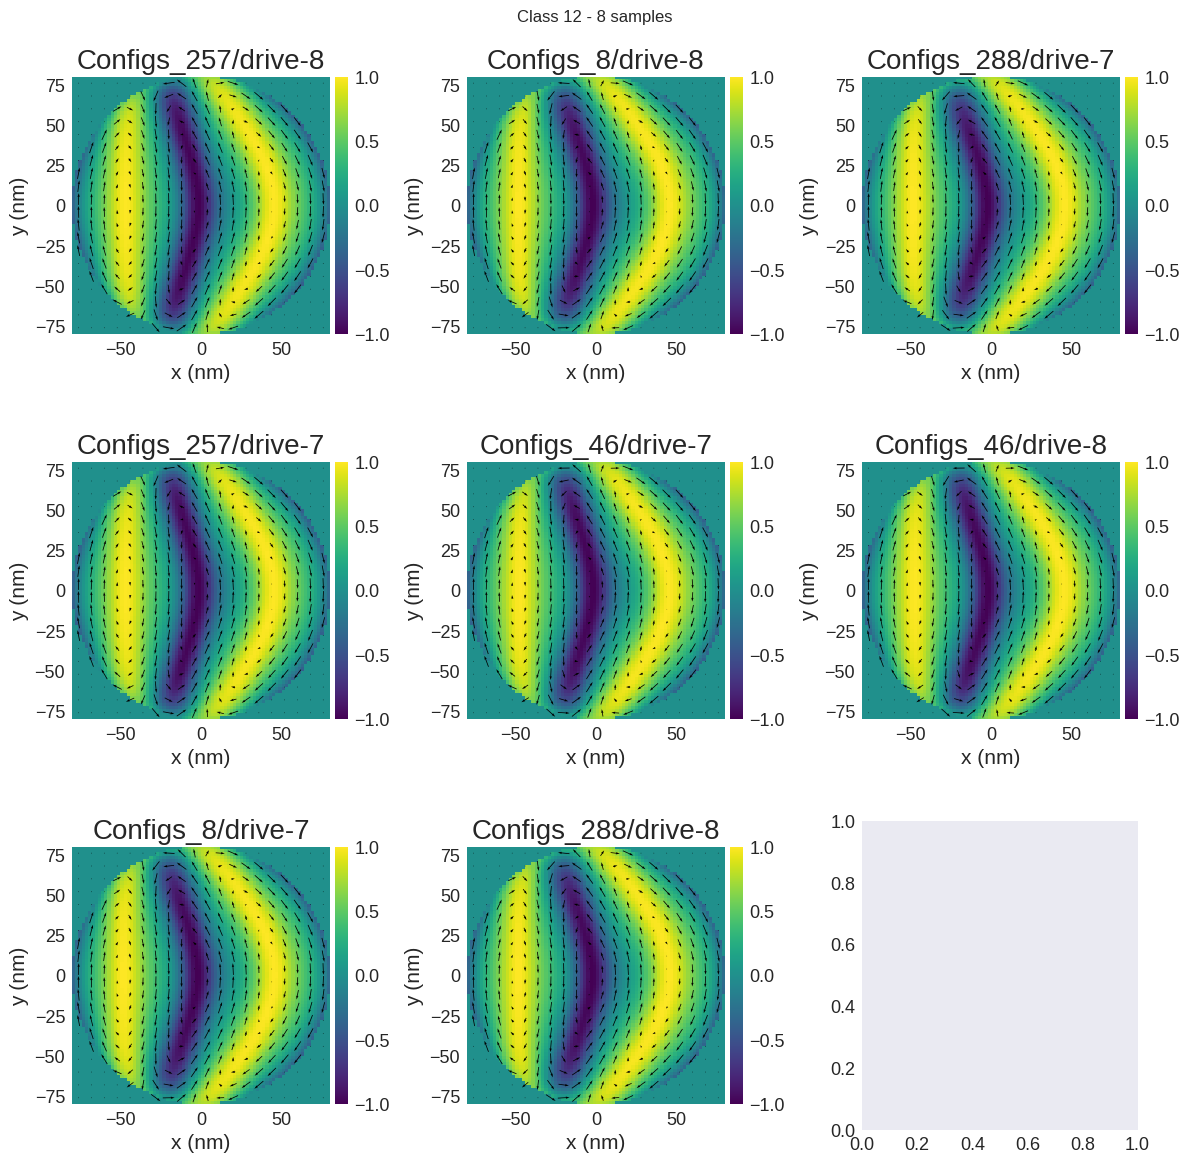

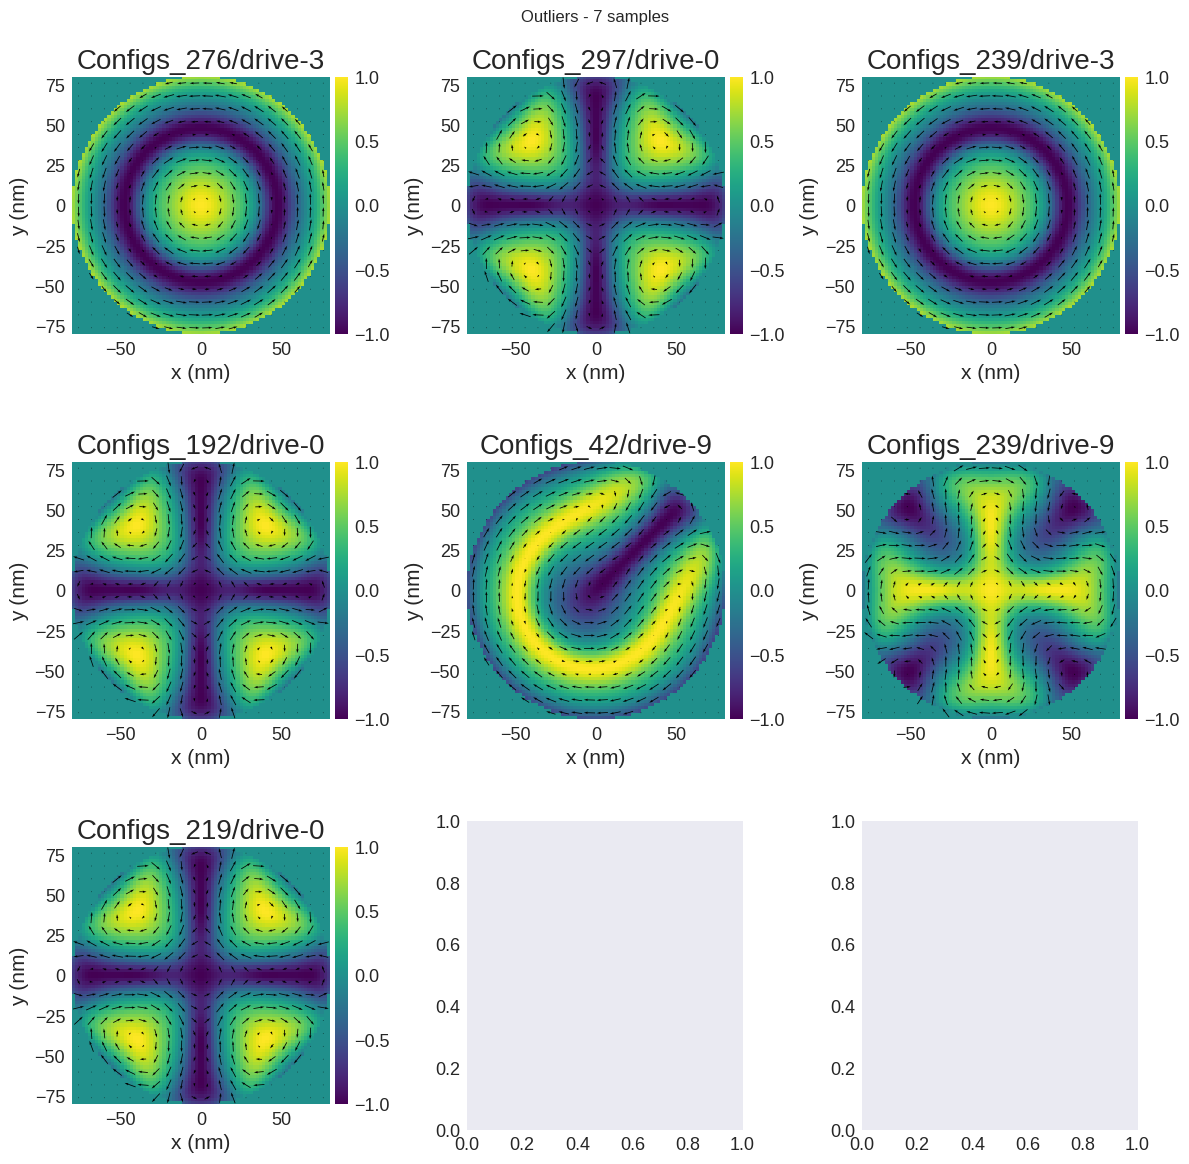

In [64]:
plot_all_examples(class_dict, parameters_dict)